# Un exemple de web scrapping avec Python
Le web scrapping est une technique d'extraction et d'organisation automatisées de données de sites web. Pour cet exemple nous utiliserons les informations fournies par l'entreprise à but non lucratif [Ecosia](https://fr.blog.ecosia.org/), un navigateur de recherche consacrant ses bénéfices à la reforestation. Dans un souci de transparence, Ecosia publie ses rapports financiers mensuels. 

L'objectif est de récupérer ces données pour visualiser leurs revenus par mois et par années, et déterminer le pourcentage reversé dans la plantation d'arbres ou autre impact climatique.

1. [Librairies utilisées](#lib)
2. [Paramètres](#param)
3. [Récupération des données](#recup)
4. [Visualisation graphique](#Visualisation-graphique)

## Librairies utilisées<a id="lib"></a>
On utilisera principalement selenium pour la recherche sur le net, numpy pour le traitement des données et pyplot pour l'affichage des résultats

In [8]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.wait import WebDriverWait 
from selenium.webdriver.support import expected_conditions as EC

from matplotlib import pyplot as plt
import numpy as np

## Paramètres<a id="param"></a>
On va visiter la page des [rapports financiers](https://fr.blog.ecosia.org/rapports-financiers-recus-de-plantations-arbres/) d'Ecosia à l'aide du navigateur Brave, piloté grâce à la librairie selenium.

In [12]:
brave_path = "C:/Program Files/BraveSoftware/Brave-Browser/Application/brave.exe"

option = webdriver.ChromeOptions()
option.binary_location = brave_path
#option.add_argument("--incognito") # OPTIONAL - brave in incognito mode
option.add_argument("--headless=old") # OPTIONAL - without opening a window

# Create new Instance of Chrome
driver = webdriver.Chrome(options=option)

url = "https://fr.blog.ecosia.org/rapports-financiers-recus-de-plantations-arbres/"
driver.get(url)

## Récupération des données<a id="recup"></a>
On le chiffre d'affaires mois par mois ainsi que la date correspondante.

In [13]:
#Scroll jusqu'à l'élément
element = WebDriverWait(driver, 100).until(EC.presence_of_element_located((By.CLASS_NAME, 'v-metric__fact--number')))
ActionChains(driver).move_to_element(element).perform()

#Ferme la bannière (sur pc)
driver.find_elements(By.CLASS_NAME,'c-install-banner__close')[-1].click()

dates = driver.find_elements(By.CLASS_NAME, 'v-select__option')
nb_dates = len(dates)

#Tableaux résultats
months = [0]*nb_dates
income = np.zeros(nb_dates, dtype=np.uint32)

print("Début de la recherche...")
for i in range(nb_dates):
    #Ouvre le menu déroulant
    driver.find_element(By.CLASS_NAME, 'v-select__value').click()

    #Choisis la date suivante
    date = driver.find_elements(By.CLASS_NAME, 'v-select__option')[i]
    date_txt = date.text
    date.click()

    #Lis les revenus / nombre d'arbres
    revenu = driver.find_elements(By.CLASS_NAME, 'v-metric__fact--number')

    #Stocke les résultats - 1ère colonne : revenu total (euros) / 2e colonne : nb arbres financés
    months[i] = date_txt
    income[i] = int("".join((revenu[0].text).split()[0].split(".")))

print("Fin de la recherche.")
driver.quit()

Début de la recherche...
Fin de la recherche.


## Visualisation graphique

In [4]:
months = [month.capitalize() for month in months[::-1]]
income = np.flip(income)/1000 #revenus en k€

### Revenus mois par mois

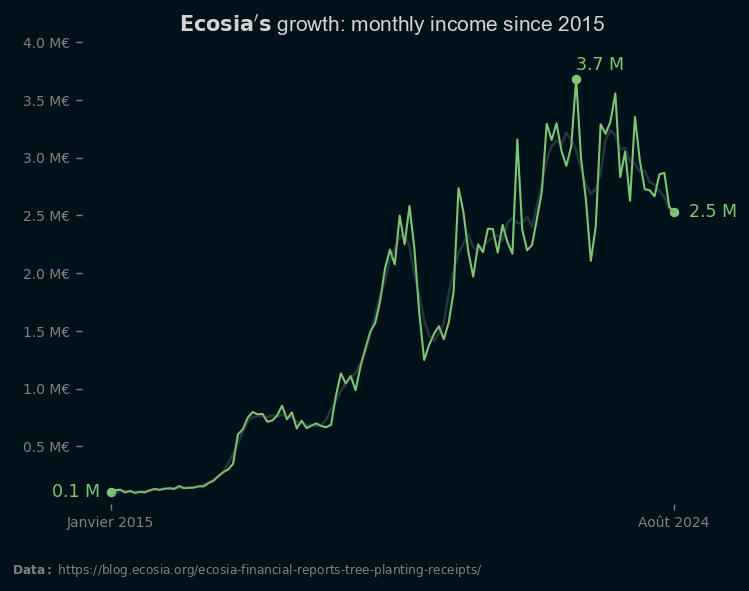

In [7]:
#Design of the graph inspired by : https://python-graph-gallery.com/web-small-multiple-with-highlights/

#Paramètres
background_color = '#001219'
linewidth_main = 1.2
color = '#7CC674'

fig, ax = plt.subplots(dpi=125)

# Set the background color
fig.set_facecolor(background_color) # background des axes
ax.set_facecolor(background_color) # background de la figure

ax.plot(months, income, color=color, linewidth=linewidth_main)

# Moyenne glissante sur 5 mois - on gère à la main les effets de bords
taille = 5
moving_average = np.convolve(income, np.ones(taille) / taille, mode='same')
for i in range(1, taille):
    if len(income) - i >= 0:
        moving_average[-i] = np.mean(income[-i:])
ax.plot(months, moving_average, color='grey', alpha=0.3)

# Highlight les endroits importants
ax.scatter(
    [months[0], months[-1]],
    [income[0], income[-1]],
    s=20, color=color,
)

plt.text(-12, income[0],                          #coordonnées
         f"{np.round(income[0], -2)/1000} M",     #texte : arrondi de la valeur
         color=color, verticalalignment='center') #paramètres
plt.text(len(months)+2, income[-1],                         
         f"{np.round(income[-1], -2)/1000} M", 
         color=color, verticalalignment='center')

# On rajoute aussi un point à la valeur max si celle-ci n'est pas trop proche du dernier point
i_max = np.argmax(income)
if (i_max < len(months)-4):
    plt.text(i_max, income[i_max]+125,                         
         f"{np.round(income[i_max], -2)/1000} M", 
         color=color, verticalalignment='center')
    ax.scatter(i_max, income[i_max], s=20, color=color)


# Cite la source des données
plt.text(-20, -600,                         
         "$\\mathbf{{Data:}}$ https://blog.ecosia.org/ecosia-financial-reports-tree-planting-receipts/", 
         color="grey", fontsize=7)


# Supprime le cadre
ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)

# Gère les axes
yticks = [f"{np.round(y, -2)/1000} M€" for y in plt.yticks()[0]]
plt.yticks(plt.yticks()[0], yticks, fontsize=8, color="grey")

ax.set_xticks([months[0], months[-1]])
ax.set_xticklabels([months[0], months[-1]], fontsize=8)

ax.tick_params(colors='grey') 


plt.title(f"$\\mathbf{{Ecosia's}}$ growth: monthly income since 2015", color='lightgrey', fontname='Arial')
plt.ylim(1)

fig.savefig(f'fig/Ecosia_monthly_income.png', bbox_inches='tight', dpi=125)
plt.show()